In [272]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import torch.nn as nn

from skimage import io
from skimage.transform import resize
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

random_state = 42
gen = random.Random(random_state)

data_dir = '../../allwavs/allvowl/corrected/extracted/img'
files = os.listdir(data_dir)
use_mel = True
files = [file for file in files if ('mel' in file) == use_mel]
#max_w = max(io.imread(data_dir + '/' + file).shape[1] for file in files)
#print(max_w)
gen.shuffle(files)
max_w = 31 # Measured

In [243]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)
    return

In [244]:
class SpectrumDataset(Dataset):
    def __init__(self, data_dir, files):
        self.data_dir = data_dir
        self.files = [file for file in files if '~' not in file.split('__')[0]]
        gen.shuffle(self.files)
        all_phonemes = ['l', 'm', 'p', 's', 't', 't1']
        self.data = []
        for file in tqdm(self.files):
            split = file.split('__')
        
            gender = split[1]
            begin_time = float(split[2])
            end_time = float(split[3])
            phonemes = split[4].split('_')
            
            image = io.imread(self.data_dir + '/' + file, as_gray=True)
            image = resize(image, (image.shape[0], max_w), anti_aliasing=False)
            
            label = (begin_time, end_time)
            self.data.append((
            (torch.tensor(image).float(),
             torch.tensor([gender == 'f', len(phonemes) == 2, *[phonemes[0] == x for x in all_phonemes]])
            ), torch.tensor(label)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

l = len(files)
train_size = 0.9
cutoff = int(l*train_size)

train_set = SpectrumDataset(data_dir, files[:cutoff])
test_set = SpectrumDataset(data_dir, files[cutoff:])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 412/412 [00:04<00:00, 85.84it/s]


tensor([[0.9870, 0.9881, 0.9946,  ..., 0.9806, 0.9484, 0.9427],
        [0.9204, 0.9132, 0.8724,  ..., 0.8641, 0.8534, 0.8515],
        [0.7980, 0.7904, 0.7474,  ..., 0.7523, 0.7330, 0.7295],
        ...,
        [0.3822, 0.3712, 0.3088,  ..., 0.2768, 0.3198, 0.3274],
        [0.3868, 0.3846, 0.3717,  ..., 0.3495, 0.3517, 0.3521],
        [0.4182, 0.4159, 0.4030,  ..., 0.3809, 0.3830, 0.3834]])
tensor([False, False, False, False,  True, False, False, False])
tensor([0.1316, 0.7895])


Text(0.5, 1.0, 'tensor([0.1316, 0.7895])')

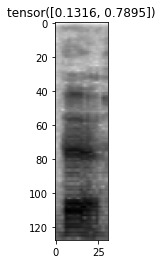

In [245]:
(im, features), label = train_set[0]
print(im)
print(features)
print(label)
plt.imshow(im.numpy(), cmap='gray')
plt.title(label)

In [346]:
class CNNRegressor(nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        
        self.cnn_layer1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size=3, padding='valid'),
                                        nn.ReLU(),
                                        nn.Dropout(0.1),
                                        nn.BatchNorm2d(16),
                                        nn.MaxPool2d(kernel_size=2))
        self.cnn_layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, padding='valid'),
                                        nn.ReLU(),
                                        nn.Dropout(0.2),
                                        nn.BatchNorm2d(32),
                                        nn.MaxPool2d(kernel_size=2))
        self.linear_layer1 = nn.Linear(32*30*6 + 8, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.activ1 = nn.ReLU()
        self.linear_layer_p = nn.Linear(64, 32)
        self.dropout_p = nn.Dropout(0.5)
        self.activ_p = nn.ReLU()
        self.linear_layer2 = nn.Linear(32, 2)
        self.activ2 = nn.Sigmoid()
        
    def forward(self, images, features):
        images = images.unsqueeze(1)
        
        cnn1 = self.cnn_layer1(images)
        cnn2 = self.cnn_layer2(cnn1)
        cnn_vec = cnn2.reshape(cnn2.shape[0], -1)
        cnn_cb = torch.cat((cnn_vec, features), dim=1)
        out = self.linear_layer1(cnn_cb)
        out = self.activ1(out)
        out = self.dropout1(out)
        out = self.linear_layer_p(out)
        out = self.dropout_p(out)
        out = self.activ_p(out)
        out2 = self.linear_layer2(out)
        out2 = self.activ2(out2)
        return out2

In [384]:
def eval_cnn_regressor(model, eval_dataloader, loss_fn):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for (images, features), labels in eval_dataloader:
            images = images.cuda()
            features = features.cuda()
            labels = labels.cuda()
            y_predicted = model(images, features)
            loss = loss_fn(y_predicted, labels)
            total_loss += loss.item()
    return total_loss/len(eval_dataloader)

def training_cnn_regressor(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):
    model_tr = copy.deepcopy(model)
    model_tr.train()
    optimizer = torch.optim.AdamW(model_tr.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    loss_all_epochs = []
    test_loss_all_epochs = []

    if verbose:
        print(f'Epoch [0/{num_epochs}], Loss: {100*eval_cnn_regressor(model_tr, train_dataloader, loss_fn):.4f}, Test loss: {100*eval_cnn_regressor(model_tr, test_dataloader, loss_fn):.4f}')
    
    total = len(train_dataloader)
    for epoch in range(num_epochs):
        loss_current_epoch = 0
        for (images, features), labels in tqdm(train_dataloader, total=total):
            images = images.cuda()
            features = features.cuda()
            labels = labels.cuda()
            y_predicted = model_tr(images, features)
            loss = loss_fn(y_predicted, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_current_epoch += loss.item()
        
        loss_all_epochs.append(loss_current_epoch / total)
        test_loss = eval_cnn_regressor(model_tr, test_dataloader, loss_fn)
        test_loss_all_epochs.append(test_loss)
        if verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {100*loss_current_epoch / total:.4f}, Test loss: {100*test_loss:.4f}')
        
    return model_tr, loss_all_epochs, test_loss_all_epochs

In [383]:
batch_size = 1
train_dataloader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_set, batch_size=batch_size)

model = CNNRegressor()

print('Total number of parameters: ', 
      sum(p.numel() for p in model.parameters()))

torch.manual_seed(0)
model.apply(init_weights)

num_epochs = 30
loss_fn = nn.BCELoss()
learning_rate = 0.01

model.cuda()
model, loss_total, test_loss_total = training_cnn_regressor(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True)

torch.save(model.state_dict(), 'model_cnn_classif.pt')
plt.plot(loss_total, label='Train loss')
plt.plot(test_loss_total, label='Test loss')
plt.legend()

plt.show()

Total number of parameters:  376258
Epoch [0/30], Loss: 73.6075, Test loss: 73.6411


  0%|▍                                                                                                        | 16/3557 [00:00<00:23, 150.82it/s]

torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.S

  1%|█▍                                                                                                       | 50/3557 [00:00<00:21, 161.38it/s]

torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.S

  3%|██▋                                                                                                      | 93/3557 [00:00<00:17, 195.89it/s]

torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.S

  4%|████▏                                                                                                   | 143/3557 [00:00<00:15, 224.55it/s]

torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.S

  6%|█████▊                                                                                                  | 200/3557 [00:00<00:13, 256.26it/s]

torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.S

  7%|███████▋                                                                                                | 262/3557 [00:01<00:11, 280.47it/s]

torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.S

  9%|█████████▍                                                                                              | 321/3557 [00:01<00:11, 285.83it/s]

torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.S

 11%|███████████▏                                                                                            | 383/3557 [00:01<00:10, 296.04it/s]

torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.S

 12%|████████████▉                                                                                           | 443/3557 [00:01<00:10, 290.48it/s]

torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.S

 14%|██████████████▋                                                                                         | 502/3557 [00:01<00:10, 287.19it/s]

torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.S

 16%|████████████████▍                                                                                       | 562/3557 [00:02<00:10, 292.09it/s]

torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1

 17%|██████████████████▏                                                                                     | 622/3557 [00:02<00:10, 287.12it/s]

torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.S

 19%|███████████████████▉                                                                                    | 681/3557 [00:02<00:09, 288.37it/s]

torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.S

 21%|█████████████████████▋                                                                                  | 742/3557 [00:02<00:09, 294.80it/s]

torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.S

 23%|███████████████████████▍                                                                                | 802/3557 [00:02<00:09, 291.36it/s]

torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.S

 24%|█████████████████████████▏                                                                              | 860/3557 [00:03<00:10, 267.08it/s]

torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.Size([1, 8])
torch.Size([1, 128, 31])
torch.S

 24%|█████████████████████████▍                                                                              | 868/3557 [00:03<00:10, 267.30it/s]

torch.Size([1, 128, 31])
torch.Size([1, 8])


KeyboardInterrupt: 

In [376]:
total = 0
for (im, ft), lb in list(test_dataloader):
    im = im.cuda()
    ft = ft.cuda()
    y_pred = model(im, ft).detach().cpu()[0]
    y_true = lb[0]
    err = torch.mean((y_true - y_pred)**2)
    total += err
    out = '-'*int(err*100)
    if out:
        print(y_true, y_pred, err.item(), out)
print(total)

tensor([0.2593, 0.7037]) tensor([0.2760, 0.8862]) 0.01679190993309021 -
tensor([0.6296, 1.0000]) tensor([0.4798, 1.0000]) 0.011220752261579037 -
tensor([0.7568, 0.9189]) tensor([0.4155, 0.8559]) 0.06022144481539726 ------
tensor([0.1200, 1.0000]) tensor([0.3243, 1.0000]) 0.02086157724261284 --
tensor([0.5454, 1.0000]) tensor([0.3848, 1.0000]) 0.012901006266474724 -
tensor([0.5862, 0.7241]) tensor([0.4845, 0.8930]) 0.01942349784076214 -
tensor([0.7727, 1.0000]) tensor([0.6279, 1.0000]) 0.010483020916581154 -
tensor([0.4800, 0.8800]) tensor([0.6677, 0.9014]) 0.017850643023848534 -
tensor([0.3333, 1.0000]) tensor([0.5074, 1.0000]) 0.015150841325521469 -
tensor([0.4688, 0.8125]) tensor([0.4701, 0.9924]) 0.016176696866750717 -
tensor([0.2963, 1.0000]) tensor([0.1372, 1.0000]) 0.012660259380936623 -
tensor([0.1622, 0.6216]) tensor([0.1117, 0.8230]) 0.02154494822025299 --
tensor([0.7667, 1.0000]) tensor([0.5318, 1.0000]) 0.027592910453677177 --
tensor([0.2857, 0.4762]) tensor([0.2474, 0.8393]

In [378]:
model4

CNNRegressor(
  (cnn_layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layer1): Linear(in_features=5768, out_features=64, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (activ1): ReLU()
  (linear_layer_p): Linear(in_features=64, out_features=32, bias=True)
  (dropout_p): Dropout(p=0.5, inplace=False)
  (activ_p): ReLU()
  (linear_layer2): Linear(in_features=32, out_fe

In [379]:
torch.save(model4.state_dict(), 'model_cnn_classif.pt')

In [380]:
torch.save(model4, 'model_cnn_regress.fl')